In [1]:
# korekta błędu w Keras po zmianie w bibliotece numpy
import numpy as np
np_load_old = np.load
np.load = lambda *a, **k: np_load_old(*a, allow_pickle=True, **k)

# wyłączenie ostrzeżeń
import warnings
import tensorflow as tf
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

# Wizualizacja efektów uczenia konwolucyjnych sieci neuronowych

Często słyszy się, że modele uczenia głębokiego są jak „czarne skrzynki”: uczą się reprezentacji, których ekstrakcja jest trudna do wykonania i trudno jest je przedstawić w formie czytelnej z punktu widzenia człowieka. Stwierdzenie to dla niektórych modeli uczenia głębokiego można uznać za częściowo prawdziwe, ale z pewnością nie jest ono prawdziwe w przypadku pracy z konwolucyjnymi sieciami neuronowymi. Reprezentacje uczone przez konwolucyjne sieci neuronowe można z łatwością przedstawić w sposób graficzny. Wynika to w dużej mierze z tego, że są to reprezentacje koncepcji graficznych. Od 2013 r. rozwinięto wiele technik wizualizacji i interpretowania takich reprezentacji. Nie będę opisywał ich wszystkich, ale przedstawię Ci trzy najprostsze rozwiązania tego typu:

* Wizualizacja pośrednich danych wyjściowych (pośrednich aktywacji) — technika przydatna do zrozumienia tego, jak kolejne warstwy sieci konwolucyjnej przekształcają dane wejściowe i tego, co robią poszczególne filtry sieci.
* Wizualizacja filtrów sieci konwolucyjnej — technika umożliwiająca dokładne zrozumienie graficznego wzorca lub graficznej koncepcji, na którą reaguje każdy z filtrów sieci konwolucyjnej.
* Wizualizacja map ciepła aktywacji klas obrazu — technika przydatna do określenia części obrazu zidentyfikowanych jako należące do danej klasy — pozwala zlokalizować obiekty widoczne na obrazach.

Działanie pierwszej techniki — wizualizacji aktywacji — sprawdzimy na przykładzie małej sieci konwolucyjnej wytrenowanej od podstaw podczas podejmowania próby rozwiązania klasyfikacji obrazów psów i kotów w podrozdziale 5.2. Działanie dwóch kolejnych technik sprawdzimy na modelu VGG16 z podrozdziału 5.3.

## Wizualizacja pośrednich aktywacji

Wizualizacja pośrednich aktywacji polega na wyświetlaniu map cech, które są generowane przez różne warstwy konwolucyjne i łączące sieci na podstawie określonych danych wejściowych (dane wyjściowe warstwy są często określane mianem aktywacji, wynikiem zwracanym przez funkcję aktywacji). Umożliwia ona podgląd tego, jak dane wejściowe są rozkładane przez różne filtry wyuczone przez sieć. Chcemy dokonać wizualizacji map cech w przestrzeni trzech wymiarów: wysokości, szerokości i głębi (kanały). Każdy kanał koduje względnie niezależne cechy, a więc w celu wykonania poprawnej wizualizacji map tych cech należy przedstawić zawartość każdego kanału w formie niezależnego dwuwymiarowego obrazu. Zacznijmy od załadowania modelu zapisanego podczas rozwiązywania problemu z podrozdziału 5.2:

In [3]:
from keras.models import load_model

model = load_model('cats_and_dogs_small_2.h5')
model.summary()  # W celu przypomnienia.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       147584    
__________

Teraz uzyskamy obraz wejściowy — zdjęcie kota niewchodzące w skład treningowego zbioru danych.

In [4]:
img_path = 'Data/test/cats/cat.1700.jpg'

# Wstępnie przetwarzamy obraz tak, aby uzyskał formę czterowymiarowego tensora.
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Pamiętaj o tym, że model był trenowany 
# na danych przetworzonych właśnie w taki sposób.
img_tensor /= 255.

# Kształt tensora: (1, 150, 150, 3).
print(img_tensor.shape)

(1, 150, 150, 3)


Czas wyświetlić zdjęcie:

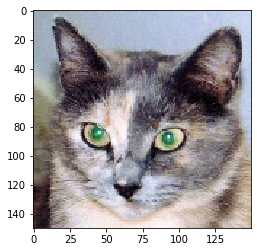

In [6]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

W celu wyciągnięcia map cech, którym chcemy się przyjrzeć utworzymy model Keras, który będzie przyjmował na wejściu wsady składające się z obrazów i generował na swoim wyjściu aktywacje wszystkich warstw konwolucyjnych i warstw łączących. W tym celu skorzystamy z klasy Model pakietu Keras. Instancję modelu utworzymy korzystając z dwóch argumentów: tensora wejściowego (lub listy tensorów wejściowych) i tensora wyjściowego (lub listy tensorów wyjściowych). Utworzona w ten sposób klasa jest modelem Keras, który podobnie do opisanych wcześniej modeli sekwencyjnych (Sequential) mapuje określone dane wejściowe do określonych danych wyjściowych. Klasę Model od klasy Sequential odróżnia to, że umożliwia ona tworzenie modeli z wieloma wyjściami. Więcej informacji na temat klasy Model znajdziesz w podrozdziale 7.1.

In [7]:
from keras import models

# Wyciąga dane wyjściowe ośmiu górnych warstw.
layer_outputs = [layer.output for layer in model.layers[:8]]
# Tworzy model zwracający dane wyjściowe generowane w wyniku przekazania określonych danych wejściowych.
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

Model ten po skierowaniu do jego wejścia obrazu zwraca wartości aktywacji warstwy oryginalnego modelu. To pierwszy przykład modelu zwracającego wiele danych wyjściowych, który został zaprezentowany w tej książce. Dotychczas przedstawiałem modele, które przyjmowały dokładnie jeden obiekt wejściowy i zwracały jeden obiekt wyjściowy, ale ogólnie rzecz biorąc, model może przyjmować dowolną liczbę obiektów wejściowych i generować dowolną liczbę obiektów wyjściowych. Opisywany aktualnie model przyjmuje jeden obiekt wejściowy i generuje osiem obiektów wyjściowych (po jednym dla każdej warstwy aktywacji).

In [9]:
# Zwraca listę pięciu tablic Numpy: po jednej tablicy dla każdej warstwy aktywacji.
activations = activation_model.predict(img_tensor)

Oto przykład aktywacji pierwszej warstwy konwolucyjnej wygenerowanej na podstawie wybranego przez nas zdjęcia kota:

In [10]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


Jest to mapa cech o rozmiarach 148x148 składająca się z 32 kanałów. Przedstawmy w formie graficznej czwarty kanał aktywacji pierwszej warstwy oryginalnego modelu:

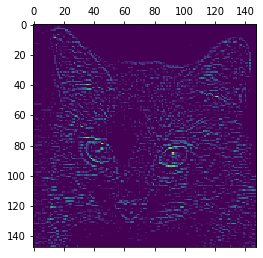

In [11]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

Kanał ten wydaje się kodować informacje o wykryciu linii ukośnych. Spróbujmy przyjrzeć się siódmemu kanałowi — pamiętaj o tym, że we własnym kodzie informacje, które zawiera mój siódmy kanał, mogą znajdować się w innym kanale, ponieważ filtry tworzone przez warstwy konwolucyjne nie mają charakteru deterministycznego.

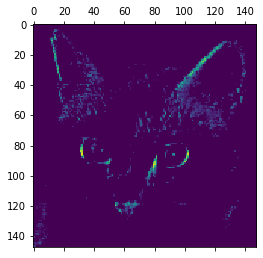

In [15]:
plt.matshow(first_layer_activation[0, :, :, 13], cmap='viridis')
plt.show()

Warstwa ta wydaje się wykrywać „jasne zielone kropki” — jest to dobry sposób na zakodowanie wizerunku kocich oczu. Wygenerujmy kompletną wizualizację wszystkich warstw aktywacji naszej sieci. Wyciągniemy dane każdego kanału ośmiu map aktywacji i przedstawimy je na wykresie majacym formę jednego dużego zbioru obrazów (kanały zostaną umieszczone obok siebie).

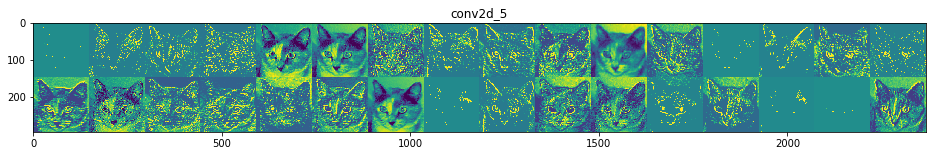

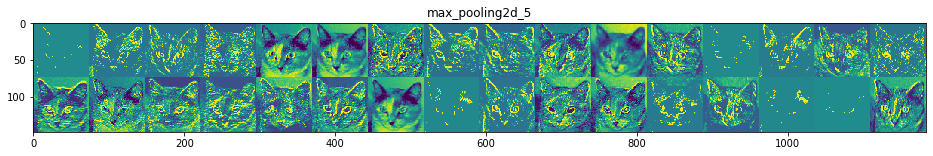

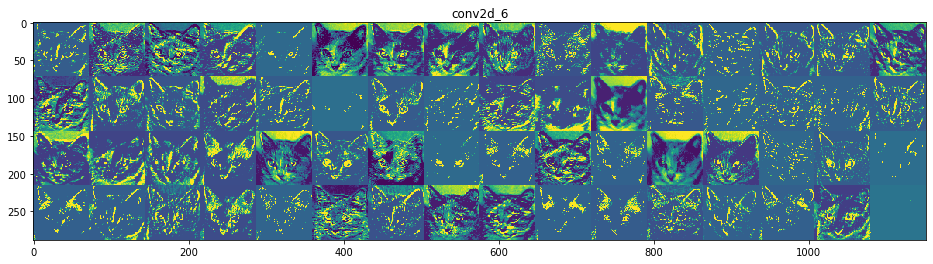

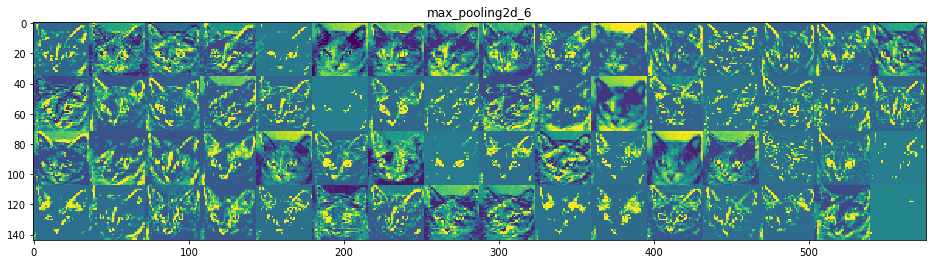

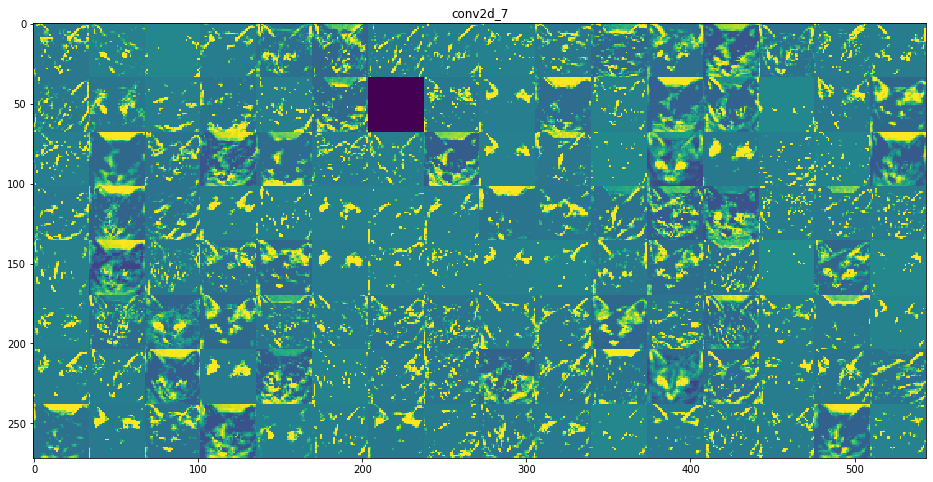

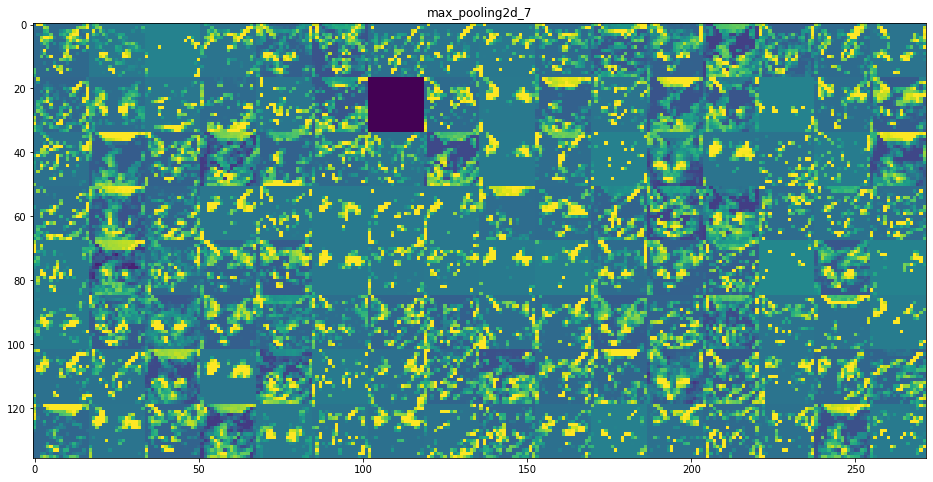

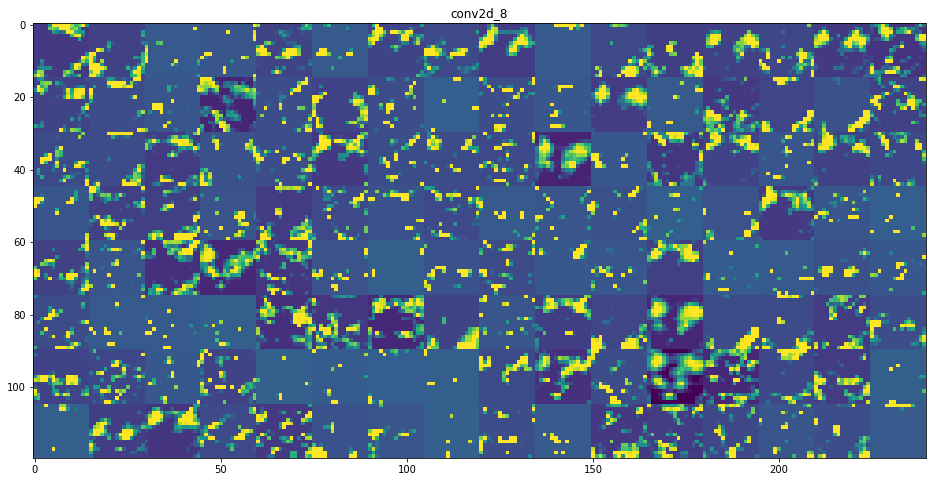

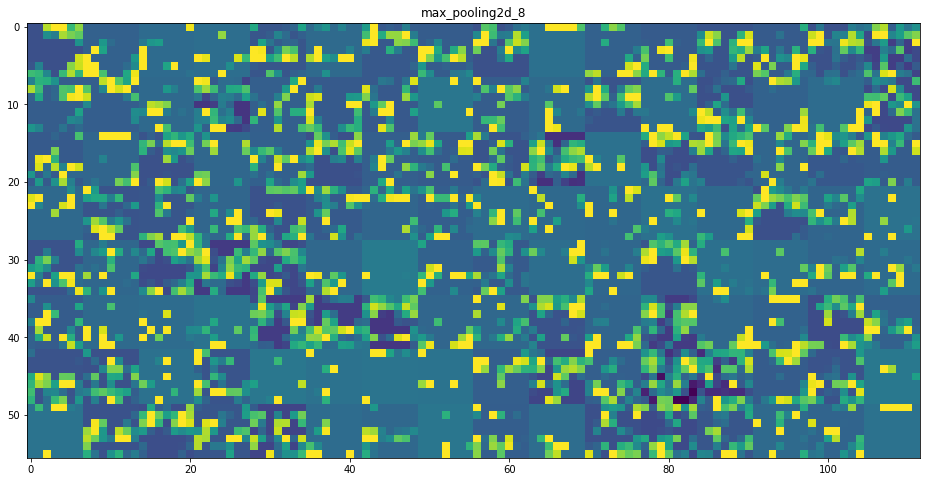

In [17]:
import keras

# Na wykresie umieścimy również nazwy warstw.
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# Wyświetla mapy cech.
for layer_name, layer_activation in zip(layer_names, activations):
    # Liczba cech w mapie.
    n_features = layer_activation.shape[-1]

    # Mapa cech ma kształt (1, size, size, n_features).
    size = layer_activation.shape[1]

    # Tworzy kafelki kanałów aktywacji w tej macierzy.
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # Tworzy poziomą siatkę składajacą się z filtrów.
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Przetwarzanie cechy w celu wygenerowania czytelnej wizualizacji.
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Wyświetla siatkę.
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

Warto zauważyć tu kilka rzeczy:

* Pierwsza warstwa wykrywa różne krawędzie. Na tym etapie aktywacje zachowują prawie wszystkie informacje obecne w początkowym obrazie.
* Kolejne warstwy aktywacji stają się coraz bardziej abstrakcyjne i trudniej je zinterpretować graficznie. Mogą one zaczynać kodować wysokopoziomowe koncepcje takie jak „kocie ucho” i „kocie oko”. Wyższe reprezentacje danych zawierają coraz mnie informacji dotyczących wizualnej zawartości obrazu i jednocześnie coraz więcej informacji związanych z klasą obrazu.
* Wraz z głębią warstw maleje ich gęstość: wszystkie filtry pierwszej warstwy są aktywowane obrazem wejściowym, ale w kolejnych warstwach coraz więcej filtrów jest pustych. Oznacza to w obrazie brak wzorca zakodowanego przez dany filtr.


Właśnie odkryliśmy ważną cechę reprezentacji uczonych przez głębokie sieci neuronowe: wraz ze wzrostem głębokości warstwy rozpoznawane przez nią cechy stają się coraz bardziej abstrakcyjne. Aktywacje wyższych warstw zawierają coraz mniej informacji o obserwacji wejściowej, jednocześnie zawierają coraz więcej informacji o celu (klasie, do której należy obraz). Głęboka sieć neuronowa pełni funkcję potoku oczyszczającego informację — na wejściu tego potoku podawany jest obraz (w tym przypadku jest to obraz w formacie RGB), który w wyniku powtarzania przekształceń jest odzierany ze zbędnych informacji (np. wizualnych parametrów danego zdjęcia), co prowadzi do wzmocnienia przydatnych informacji, na podstawie których można ustalić klasę, do której należy obraz.

W taki sam sposób świat postrzegają ludzie i zwierzęta: po obserwowaniu jakiejś sceny przez kilka sekund człowiek zapamiętuje abstrakcyjne obiekty, które były w niej obecne (takie jak rower lub drzewo), ale nie pamięta konkretnego wyglądu tych obiektów. Spróbuj narysować rower z pamięci. Najprawdopodobniej będzie to problematyczne pomimo tego, że z pewnością zdarzyło Ci się w życiu widzieć rowery wielokrotnie. Spróbuj to zrobić teraz. Nasz mózg naprawdę działa, ucząc się abstrakcji bodźców wizualnych i odzierając je ze zbędnych szczegółów. Przez to zjawisko dość trudno jest zapamiętać detale wyglądu otaczających nas rzeczy.

## Wizualizacja filtrów konwolucyjnych sieci neuronowych


Innym łatwym sposobem na przyjrzenie się działaniu filtrów konwolucyjnej sieci neuronowej jest wyświetlenie graficznego wzorca, na który reaguje każdy z filtrów. Można to zrobić poprzez zwiększanie gradientu w przestrzeni wejściowej: zastosowanie algorytmu spadku gradientowego na wartości obrazu wejściowego konwolucyjnej sieci neuronowej w celu zmaksymalizowania odpowiedzi wybranego filtra, zaczynając od pustego obrazu wejściowego. Technika ta pozwala na uzyskanie obrazu wejściowego, na który wybrany filtr reaguje w sposób maksymalny.

Proces ten jest prosty: wystarczy zbudować funkcje straty maksymalizującą wartość wybranego filtra w wybranej warstwie konwolucyjnej, a następnie skorzystać z algorytmu stochastycznego spadku gradientowego w celu zmodyfikowania obrazu wejściowego, tak aby uzyskać maksymalną wartość aktywacji. Oto przykład funkcji straty aktywacji filtra 0 warstwy block3_conv1 sieci VGG16 wytrenowanej na zbiorze obrazów ImageNet.

In [18]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',
              include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

W celu zaimplementowania algorytmu spadku gradientowego będziemy musieli ustalić gradient straty z uwzględnieniem danych wejściowych modelu. W związku z tym skorzystamy z funkcji gradients znajdującej się w module backend pakietu Keras.

In [19]:
# Wywołanie funkcji gradients zwraca listę tensorów (w tym przypadku ma ona rozmiar 1.
# W związku z tym zapisujemy tylko pierwszy element tej listy, który jest potrzebnym nam tensorem.
grads = K.gradients(loss, model.input)[0]

Niezbyt oczywistym rozwiązaniem wspomagającym algorytm spadku gradientowego jest normalizacja tensora gradientu poprzez podzielenie go przez jego normę L2 (pierwiastek kwadratowy średniej kwadratów wartości tensora). Zapewni to stały zakres modyfikacji obrazu wejściowego.

In [20]:
# Przed dzieleniem dodawana jest wartość 1e–5 w celu zapobiegnięcia przypadkowemu dzieleniu przez zero.
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

Teraz musimy jakoś obliczyć wartość tensora straty i tensora gradientu. W tym celu możemy zdefiniować wewnętrzna funkcję pakietu Keras: funkcja iterate przyjmuje tensor Numpy (w formie listy tensorów o rozmiarze 1) i zwraca listę dwóch tensorów Numpy: wartość straty i wartość gradientu.

In [21]:
iterate = K.function([model.input], [loss, grads])

# Sprawdźmy to.
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

Teraz możemy zdefiniować pętlę implementującą stochastyczny spadek wzdłuż gradientu:

In [22]:
# Zaczynamy od szarego obrazu z szumem.
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

# Wykonuje 40 kroków algorytmu zwiększania gradientu.
step = 1.  # Waga każdej aktualizacji gradientu.
for i in range(40):
    # Obliczamy wartość straty i wartość gradientu.
    loss_value, grads_value = iterate([input_img_data])
    # Modyfikuje obraz wejściowy tak, aby uzyskać jak najwyższą wartość straty.
    input_img_data += grads_value * step

Uzyskany w ten sposób tensor obrazu jest tensorem liczb zmiennoprzecinkowych o kształcie (1, 150, 150, 3). Znajdują się w nim wartości z zakresu od 0 do 255, które nie muszą być liczbami całkowitymi. W związku z tym w celu wyświetlenia obrazu musimy jeszcze przetworzyć ten tensor. Zrobimy to za pomocą prostej funkcji narzędziowej:

In [23]:
def deprocess_image(x):
    # Normalizacja tensora: wyśordkowanie w punkcie 0, zapewnienie odchylenia standardowego równego 0,1.
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # Ograniczenie do zakresu [0, 1].
    x += 0.5
    x = np.clip(x, 0, 1)

    # Konwersja na formę tablicy RGB.
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

Mamy już wszystkie elementy, których potrzebujemy. Połączmy je w celu utworzenia funkcji przyjmującej w charakterze parametru wejściowego nazwę warstwy i indeks filtru. Funkcja ta powinna zwracać gotowy obraz wzorca maksymalizującego aktywację wybranego filtra.

In [24]:
def generate_pattern(layer_name, filter_index, size=150):
    # Buduje funkcję straty maksumalizującą aktywację n-tego filtra analizowanej warstwy.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Oblicza gradient obrazu wejściowego z uwzględnieniem wartości straty.
    grads = K.gradients(loss, model.input)[0]

    # Sztuczka normalizująca gradient.
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # Funkcja zwracająca stratę i gradient dla danego obrazu wejściowego.
    iterate = K.function([model.input], [loss, grads])
    
    # Zaczynamy od szarego obrazu z szumem.
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Wykonuje 40 kroków algorytmu zwiększania gradientu.
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

Wypróbujmy działanie tej funkcji:

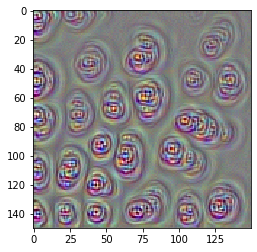

In [28]:
plt.imshow(generate_pattern('block3_conv3', 20))
plt.show()

Wygląda na to, że filtr nr 0 warstwy block3_conv1 reaguje na wzór kropek. Teraz możemy zacząć zabawę i przyjrzeć się wizualizacjom wszystkich filtrów wchodzących w skład wszystkich warstw. Dla uproszczenia przyjrzymy się 64 pierwszym filtrom każdej warstwy i będziemy brać pod uwagę tylko pierwszą warstwę każdego bloku konwolucji (block1_conv1, block2_conv1, block3_conv1, block4_conv1 i block5_conv1). Wygenerowane wartości umieścimy w siatce o wymiarach 8x8 składającej się z wzorów filtrów o rozdzielczości 64x64, a między wzorami umieścimy czarne linie rozgraniczające.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


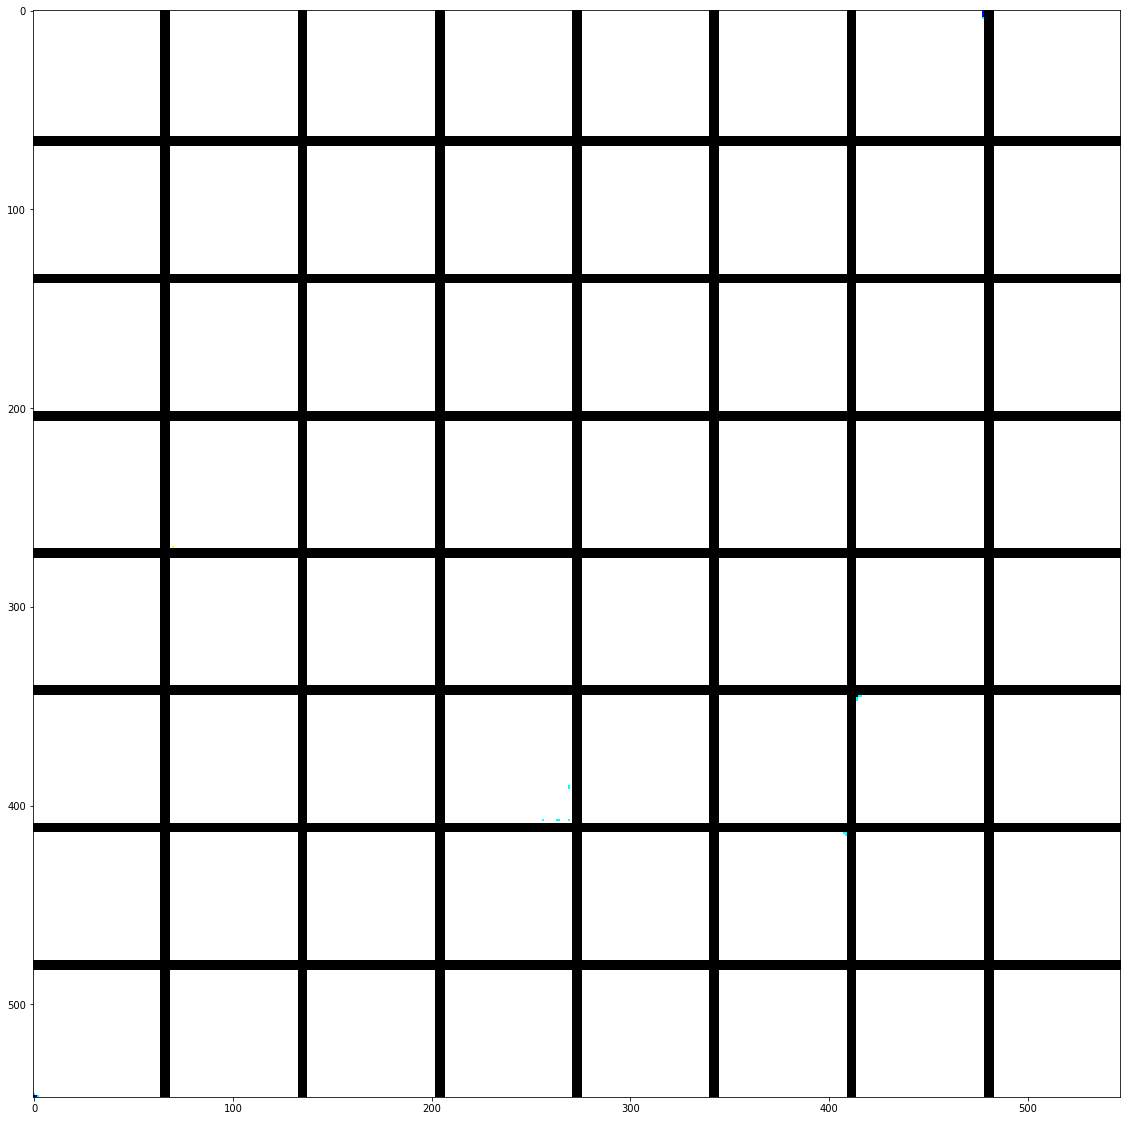

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


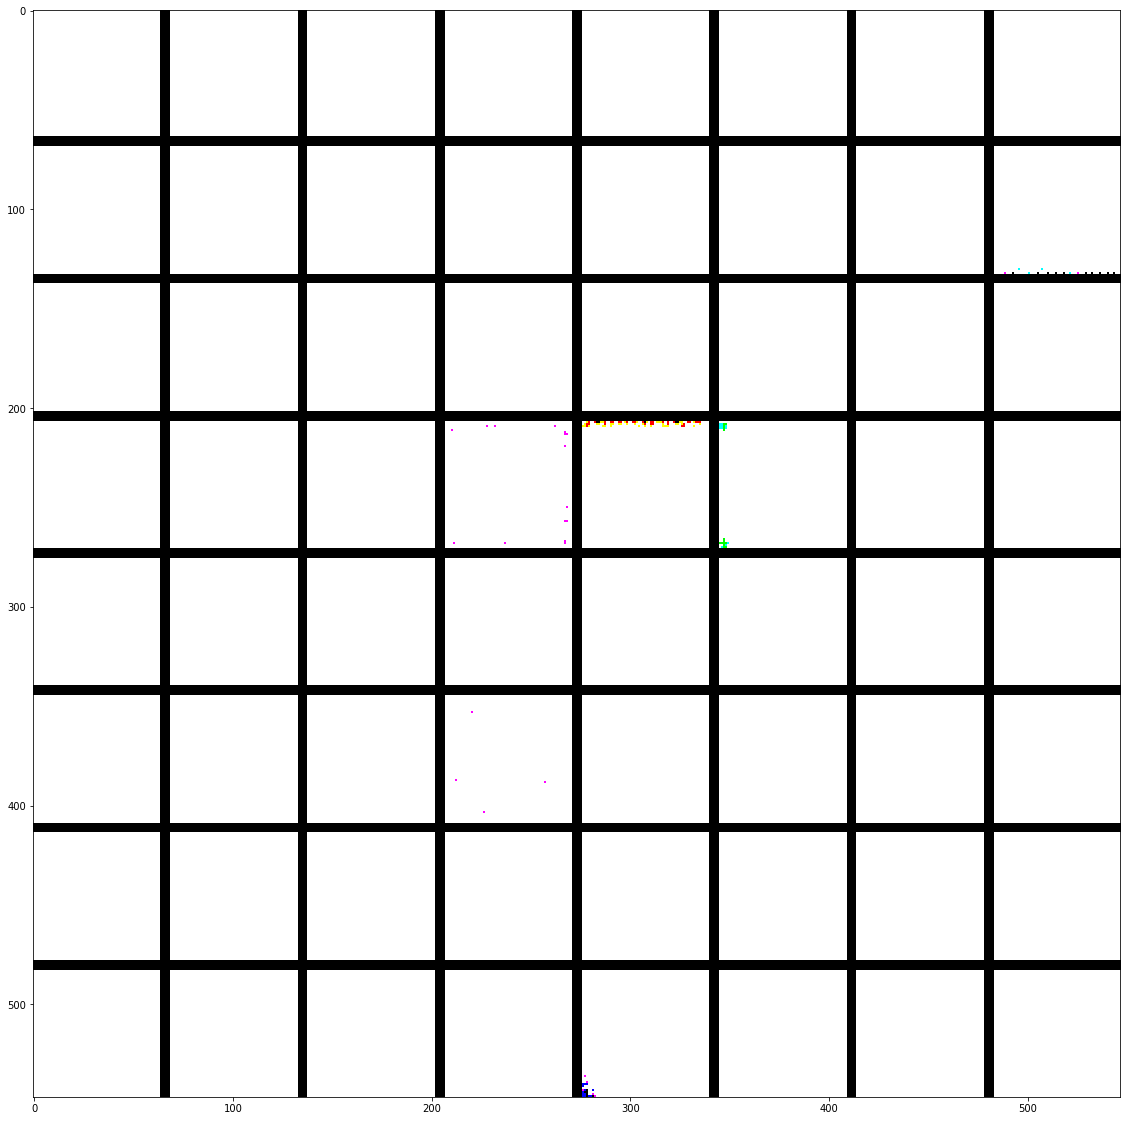

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


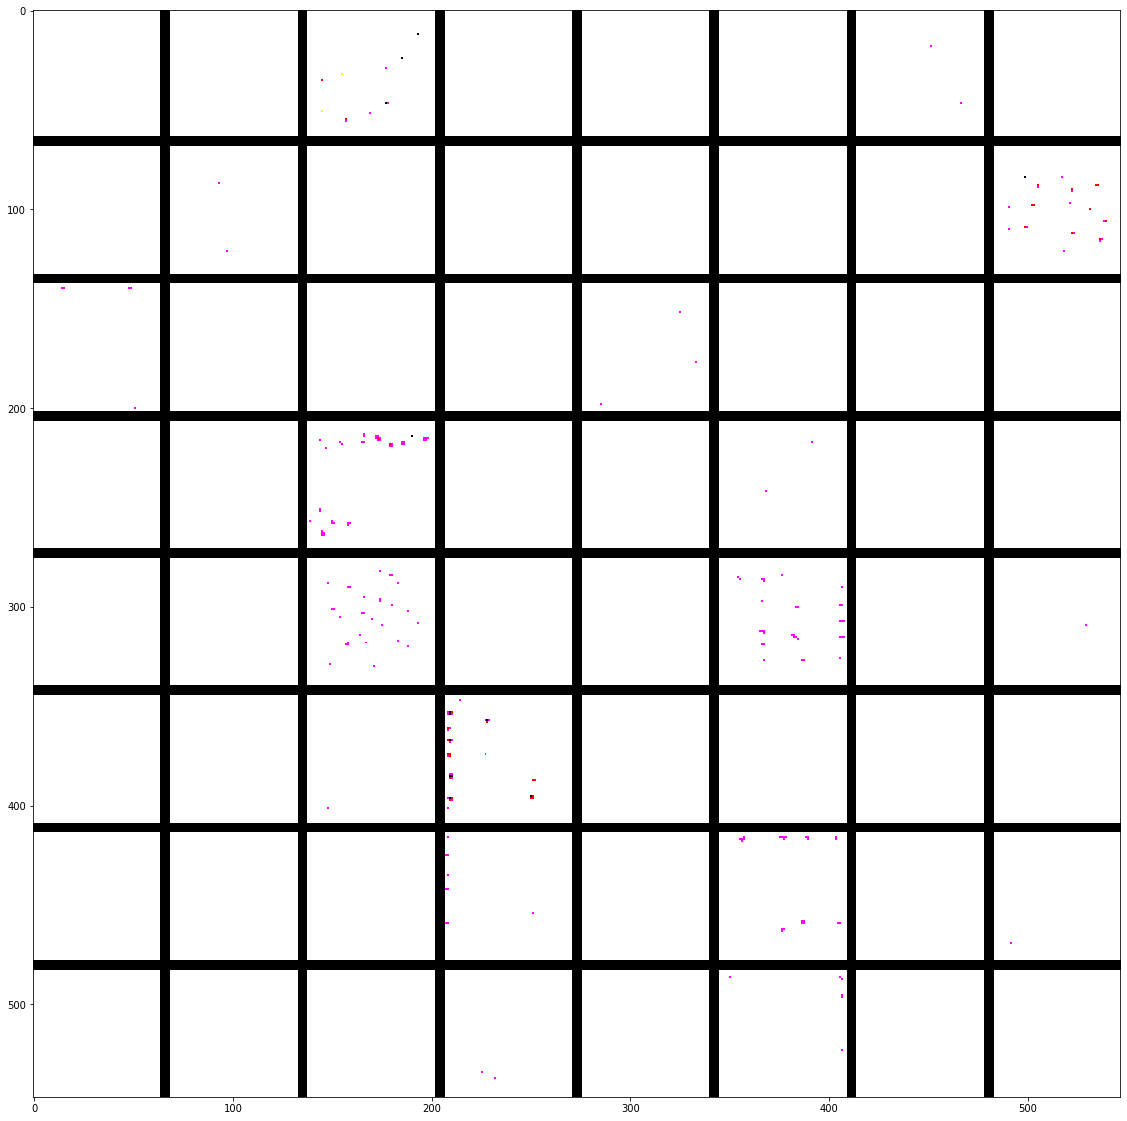

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


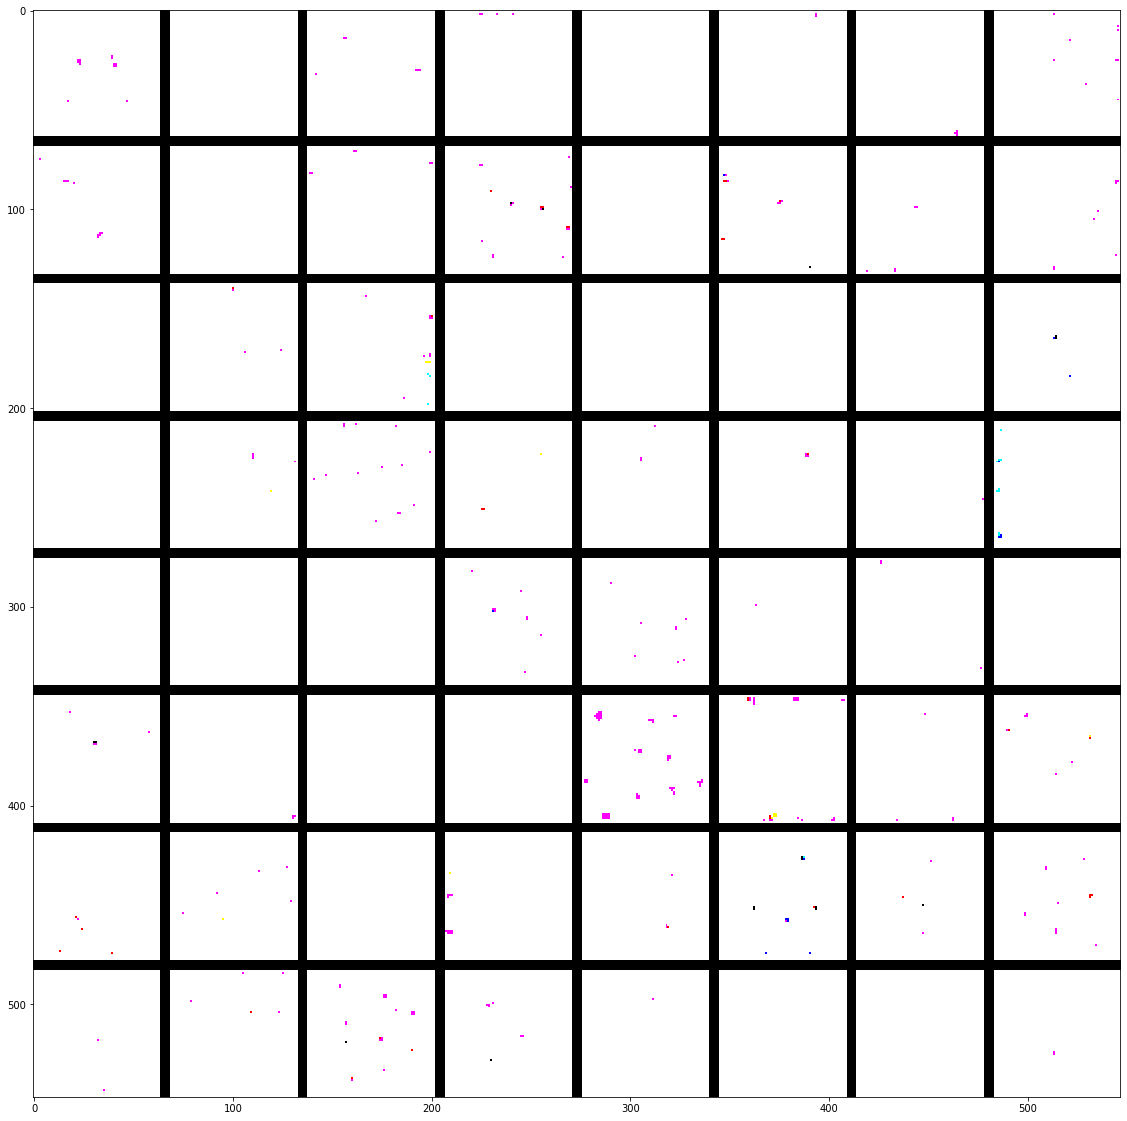

In [27]:
for layer_name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']:
    size = 64
    margin = 5

    # Pusty czarny obraz, na którym umeiszczać będziemy uzyskane wyniki.
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    for i in range(8):  # Iteracja po wierszach siatki wyników.
        for j in range(8):  # Iteracja po kolumnach siatki wyników.
            # Generuje wzorzec filtra i + (j * 8) warstwy layer_name.
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

            # Umieszcza wynik w kwadracie o współrzędnych (i, j) siatki wyników.
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Wyświetla siatkę wyników.
    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.show()

Na podstawie tych wizualizacji można dowiedzieć się, jak warstwy sieci neuronowej widzą obrazy: każda warstwa konwolucyjnej sieci neuronowej uczy się zbioru filtrów umożliwiających przedstawienie danych wejściowych za pomocą kombinacji tych filtrów. Rozwiązanie to działa podobnie do transformacji Fouriera rozkładającej sygnał na zbiór funkcji cosinusowych. Filtry tej konwolucyjnej sieci neuronowej stają się coraz bardziej złożone i lepsze wraz ze zwiększaniem się ich pozycji w modelu:

* Filtry pierwszej warstwy modelu (block1_conv1) kodują proste kierunkowe krawędzi i koloru (w niektórych przepadkach są to kolorowe krawędzie).
* Filtry warstwy block2_conv1 kodują proste tekstury składające się z kombinacji krawędzi i kolorów.
* •	Filtry wyższych warstw zaczynają przypominać tekstury naturalnych obrazów: pióra, oczy, liście itp.

## Wizualizacja map ciepła aktywacji klas

Chciałbym przedstawić jeszcze jedną technikę wizualizacji. Przydaje się ona w celu określenia części obrazu, które doprowadziły sieć neuronową do podjęcia decyzji o zaklasyfikowaniu go do danej klasy. Rozwiązanie to przydaje się podczas debugowania procesu decyzyjnego konwolucyjnej sieci neuronowej w przypadku podejmowania przez nią błędnych decyzji. Ponadto pozwala ono na zlokalizowanie określonego obiektu na obrazie.

Tę ogólną kategorię technik określamy mianem wizualizacji map aktywacji klas (map CAM). Rozwiązania te polegają na generowaniu map ciepła aktywacji klas naniesionych na obrazy wejściowe. Mapa ciepła aktywacji klas jest dwuwymiarową siatką wyników związanych z określoną klasą wyjściową. Wyniki te są obliczane dla każdego punktu obrazu wejściowego. Określają one to, jak ważny jest dany punkt z uwagi na wybraną klasę. W przypadku przykładowego obrazu przekazanego do sieci klasyfikującej obrazy na zdjęcia psów i zdjęcia kotów wizualizacja map aktywacji klasy pozwala na wygenerowanie mapy ciepła aktywacji klasy „kot” określającej to, jak bardzo poszczególne części obrazu swym wyglądem przypominają kota. Możemy wygenerować również mapę ciepła klasy „pies” określającą to, jak bardzo poszczególne części obrazu przypominają psa.

Będziemy korzystać z implementacji opisanej w artykule [Grad-CAM: Why did you say that? Visual Explanations from Deep Networks via 
Gradient-based Localization](https://arxiv.org/abs/1610.02391). To bardzo prosta implementacja polegająca na przechwytywaniu wyjściowej mapy cech warstwy konwolucyjnej powstałej w wyniku przetwarzania danego obrazu. Następnie określane są wagi poszczególnych kanałów tej mapy (używany jest do tego algorytm spadku gradientowego klasy z uwzględnieniem kanału). Technikę tę można zrozumieć jako ważenie przestrzennych map „intensywności aktywowania różnych kanałów przez obraz wejściowy” i „istotności każdego kanału z punktu widzenia wybranej klasy” — generowana mapa określa „intensywność aktywacji klasy przez obraz wejściowy”.

Przyjrzymy się tej technice, ponownie korzystając z wytrenowanej sieci VGG16.

In [ ]:
from keras.applications.vgg16 import VGG16

K.clear_session()

# Zwróć uwagę na to, że dołączamy gęsto połączony klasyfikator. 
# We wcześniejszych przykładach nie korzystaliśmy z niego.
model = VGG16(weights='imagenet')

Przyjrzyjmy się zdjęciu afrykańskich słoni udostępnionemu na mocy licencji Creative Commons:

![elephants](https://s3.amazonaws.com/book.keras.io/img/ch5/creative_commons_elephant.jpg)

Prawdopodobnie jest to matka ze słoniątkiem podczas spaceru po sawannie. Zamieńmy ten obraz na format, który może zostać przetworzony przez model VGG16. Model ten został wytrenowany na obrazach o rozdzielczości 224x244 przygotowanych zgodnie z wytycznymi mającymi postać funkcji keras.applications.vgg16.preprocess_input. W związku z tym musimy wczytać obraz, zmienić jego rozdzielczość na 224x224, dokonać jego konwersji na tensor Numpy z wartościami typu float32 i wykonać pozostałe operacje wstępnej obróbki obrazu.

In [ ]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

# Lokalna ścieżka obrazu.
img_path = 'creative_commons_elephant.jpg'

# Obraz biblioteki Python Image Library (PIL) o rozdzielczości 224x224,
img = image.load_img(img_path, target_size=(224, 224))

# Tablica Numpy wartości float32 o kształcie (224, 224, 3).
x = image.img_to_array(img)

# Operacja dodawania wymiaru w celu wykonania transformacji tablicy do postaci wsadu o rozmiarze (1, 224, 224, 3).
x = np.expand_dims(x, axis=0)

# Wstępna obróbka wsadu (normalizacja kanałów poszczególnych kolorów).
x = preprocess_input(x)

In [ ]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])


Oto trzy najbardziej prawdopodobne klasy tego obrazu:

* słoń afrykański (prawdopodobieństwo 92,5%),
* dorosły słoń (prawdopodobieństwo 7%),
* słoń indyjski (prawdopodobieństwo 0,4%).

Sieć doszła do wniosku, że na obrazie znajduje się niewiadoma liczba słoni afrykańskich. Element wektora predykcji, który uzyskał maksymalną wartość aktywacji, odpowiada klasie „słoń afrykański” (African_elephant) o numerze indeksu 386:

In [ ]:
np.argmax(preds[0])

W celu określenia elementów obrazu, które najbardziej świadczą o tym, że znajduje się na nim słoń afrykański, skonfigurujmy proces generowania mapy aktywacji klas.

In [ ]:
# Wartość wektora predykcji odwołująca się do klasy „słoń afrykański”.
african_elephant_output = model.output[:, 386]

# Wyjściowa mapa cech warstwy block5_conv3 — ostatniej warstwy konwolucyjnej modelu VGG16.
last_conv_layer = model.get_layer('block5_conv3')

# Gradient klasy „słoń afrykanski” uwzględniający wyjściową mapę cech warstwy block5_conv3.
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# Wektor o kształcie (512,). Każda wartość tego wektora jest średnią intensywności 
# gradientu przy określonym kanale mapy cech.
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# Pozwala na uzyskanie dostępu do 
# zdefiniowanych przed chwilą wartości pooled_grads i wyjściowej mapy cech block5_conv3.
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# Wartości dwóch niewiadomych w formie tablic Numpy 
# (wartości te powstały w wyniku przetwarzania obrazu dwóch słoni).
pooled_grads_value, conv_layer_output_value = iterate([x])

# Mnożenie każdego kanału tablicy mapy cech przez wartość określającą 
# „jego wpływ na to, że obraz przedstawia słonia”.
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# Średnia kanałów wyjściowej mapy cech jest mapą ciepła aktywacji klasy.
heatmap = np.mean(conv_layer_output_value, axis=-1)

Chcemy wygenerować wizualizację, a więc przeprowadzimy normalizację wartości map ciepła do zakresu 0 – 1:

In [ ]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

Na koniec skorzystamy z narzędzia OpenCV w celu nałożenia wygenerowanej mapy ciepła na oryginalny obraz:

In [ ]:
import cv2

# Wczytujemy oryginalny obraz za pomocą modułu cv2.
img = cv2.imread(img_path)

# Zmieniamy rozdzielczość mapy ciepła tak, aby miała ona taką samą rozdzielczość jak analizowane zdjęcie.
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# Konwersja mapy cieplnej na płaszczyznę RGB.
heatmap = np.uint8(255 * heatmap)

# Nakładamy mapę cieplną na oryginalny obraz.
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Określamy wartość współczynnika intensywności mapy cieplnej (0,4).
superimposed_img = heatmap * 0.4 + img

# Zapisujemy obraz na dysku.
cv2.imwrite('elephant_cam.jpg', superimposed_img)

![elephant cam](https://s3.amazonaws.com/book.keras.io/img/ch5/elephant_cam.jpg)

Korzystając z tej techniki, możemy odpowiedzieć na dwa pytania:

* Dlaczego sieć uważa, że na tym zdjęciu znajduje się słoń afrykański?
* W którym miejscu fotografii znajduje się słoń afrykański?

Ciekawą obserwacją jest to, że uszy małego słonia wywołują największą aktywację sieci. Ten szczegół zdjęcia pokazuje prawdopodobnie element, po którym sieć odróżnia słonia afrykańskiego od słonia indyjskiego.
